In [ ]:
! pip install gdown --quiet

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Library imports
from glob import glob
import os
from PIL import Image, ImageFilter
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2 as cv
import random
from os import listdir
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
import gdown

In [5]:
url = 'https://drive.google.com/uc?id=1KV3ptqS36gdsVrDzBTB8Ey6pJLWrT5LI'
output = 'aksara.zip'
gdown.download(url, output)

!unzip -q aksara.zip -d /kaggle/working

Downloading...
From (original): https://drive.google.com/uc?id=1KV3ptqS36gdsVrDzBTB8Ey6pJLWrT5LI
From (redirected): https://drive.google.com/uc?id=1KV3ptqS36gdsVrDzBTB8Ey6pJLWrT5LI&confirm=t&uuid=57e1653d-e9ee-4bd7-b4a3-05925059a281
To: /kaggle/working/aksara.zip
100%|██████████| 66.8M/66.8M [00:00<00:00, 226MB/s]


In [3]:
url = 'https://drive.google.com/uc?id=1NnBeaUFgVBtlFHkWSNEfYqHY4VevajeG'
output = 'hasil_final.zip'
gdown.download(url, output)

!unzip -q hasil_final.zip -d /kaggle/working

Downloading...
From (original): https://drive.google.com/uc?id=1NnBeaUFgVBtlFHkWSNEfYqHY4VevajeG
From (redirected): https://drive.google.com/uc?id=1NnBeaUFgVBtlFHkWSNEfYqHY4VevajeG&confirm=t&uuid=e09d0eb2-17b1-4bbe-a90b-9f2095e9b53e
To: /kaggle/working/hasil_final.zip
100%|██████████| 4.35G/4.35G [00:25<00:00, 170MB/s] 


In [3]:
! rm /kaggle/working/hasil_final.zip

In [4]:
def tambahMargin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

def cropGambar(img, frac=.7):
    left = img.size[0]*((1-frac)/2)
    upper = img.size[1]*((1-frac)/2)
    right = img.size[0]-((1-frac)/2)*img.size[0]
    bottom = img.size[1]-((1-frac)/2)*img.size[1]
    cropped_img = img.crop((left, upper, right, bottom))
    return cropped_img

def showImage(img, title=None):
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    
def buatKotak(img):
    h, w = img.shape[:2]
    
    if h > w:
        new_w = int((h - w) / 2)
        return cv.copyMakeBorder(img, 0, 0, new_w, new_w, cv.BORDER_CONSTANT, None, value=0)
    else:
        new_h = int((w - h) / 2)
        return cv.copyMakeBorder(img, new_h, new_h, 0, 0, cv.BORDER_CONSTANT, None, value=0)
    
def tambahMargin(img, persen = 0):
    h, w = img.shape[:2]
    new_h = int(h * persen / 2)
    new_w = int(w * persen / 2)
    return cv.copyMakeBorder(img, new_h, new_h, new_w, new_w, cv.BORDER_CONSTANT, None, value=0)

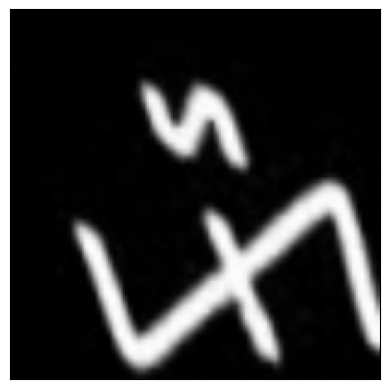

In [53]:
tete = cv.imread('/kaggle/working/content/hasil_final/Ca/Car/179.jpg')
gray = cv.cvtColor(tete, cv.COLOR_BGR2GRAY)
invert = cv.bitwise_not(gray)
resized = cv.resize(invert, (200, 200))
showImage(resized)

In [52]:
resized.shape

(50, 50)

In [54]:
data_latih = {'image': [], 'label': []}
train_root = "/kaggle/working/content/hasil_final/"
list_folder = glob(train_root + "*/")
for folder in list_folder:
    for isi_folder in glob(folder + "*/"):
        for aksara in glob(isi_folder + '*'):
            data_latih['label'].append(aksara.split("/")[-2])
            image = cv.imread(aksara)
            gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
            invert = cv.bitwise_not(gray)
            resized = cv.resize(invert, (50, 50))
            data_latih['image'].append(resized)

# data_latih_df = pd.DataFrame(data_latih)

In [56]:
data_latih['normalized'] = np.array(data_latih['image']) / 255
le = LabelEncoder()
data_latih['coded_label'] = le.fit_transform(data_latih['label'])
X = data_latih['normalized']
y = data_latih['coded_label']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=20)

In [58]:
image_rows = 50
image_cols = 50
batch_size = 4096
image_shape = (image_rows,image_cols,1) 

In [59]:
X_train = X_train.reshape(X_train.shape[0],*image_shape)
X_test = X_test.reshape(X_test.shape[0],*image_shape)

In [60]:
X_train = np.array(X_train, dtype = 'float32')
X_test = np.array(X_test, dtype = 'float32')

In [87]:
cnn_model = Sequential([
    Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = image_shape),
    MaxPooling2D(pool_size=2) ,# down sampling the output instead of 28*28 it is 14*14
    Dropout(0.2),
    Flatten(), # flatten out the layers
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(258,activation = 'softmax')  
])

In [88]:
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001),metrics =['accuracy'])

In [89]:
history = cnn_model.fit(
    X_train,
    y_train,
    batch_size=4096,
    epochs=100,
    verbose=1,
    validation_data=(X_test,y_test),
)

Epoch 1/100


2024-03-16 08:03:00.058787: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


23/23 [==============================] - ETA: 0s - loss: 5.3692 - accuracy: 0.0222

KeyboardInterrupt: 

In [ ]:
epochs = range(100)
plt.plot(epochs, history.history['accuracy'], label='Training Acc')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Acc')
 
# Add in a title and axes labels
plt.title('Training and Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [72]:
cnn_model.evaluate(X_test, y_test, verbose=0)

[0.464245080947876, 0.9220499396324158]

In [17]:
cnn_model.save('konversi_aksara_model', save_format='tf')

In [18]:
!zip -r /kaggle/working/konversi_aksara_model.zip /kaggle/working/konversi_aksara_model

  adding: kaggle/working/konversi_aksara_model/ (stored 0%)
  adding: kaggle/working/konversi_aksara_model/assets/ (stored 0%)
  adding: kaggle/working/konversi_aksara_model/saved_model.pb (deflated 86%)
  adding: kaggle/working/konversi_aksara_model/fingerprint.pb (stored 0%)
  adding: kaggle/working/konversi_aksara_model/variables/ (stored 0%)
  adding: kaggle/working/konversi_aksara_model/variables/variables.index (deflated 61%)
  adding: kaggle/working/konversi_aksara_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/konversi_aksara_model/keras_metadata.pb (deflated 89%)


In [21]:
import tensorflow as tf

In [22]:
tf.version.VERSION

'2.15.0'

In [ ]:
teks = []
for folder in glob('/kaggle/input/augmented-tes/kaggle/working/hasil/*'):
    kata = ""
    for file in glob(folder + '/*'):
        image = cv.imread(file)
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        blur = cv.GaussianBlur(gray, (9, 9), 0)
        _, thresh = cv.threshold(blur, 150, 255, cv.THRESH_BINARY_INV)
        kotak = buatKotak(thresh)
        margin = tambahMargin(kotak, .4)
        resized = cv.resize(margin, (50, 50))
        to_predict = resized.reshape(1, *resized.shape, 1)
        predicted = le.inverse_transform([np.argmax(cnn_model.predict(to_predict, verbose=0))])
        showImage(resized, predicted)
        kata += predicted[0]
    teks.append(kata)
" ".join(teks)

In [49]:
tes_predict.shape

(1, 28, 28, 1)

In [47]:
m = 90
tes_predict = X_test[m].reshape(1, *X_test[1].shape)
print("Prediksi :", le.inverse_transform([np.argmax(cnn_model.predict(tes_predict))]))
print("Asli     :", le.inverse_transform([y_test[m]]))

1/1 [==============================] - 0s 133ms/step
Prediksi : ['Ai']
Asli     : ['Ai']


In [21]:
url = 'https://drive.google.com/uc?id=1ToCXJr8ctgEpBO2R5FOWPYo4lFcRWHwo'
output = 'testi.zip'
gdown.download(url, output)

!unzip -q testi.zip -d /kaggle/working/coba

Downloading...
From: https://drive.google.com/uc?id=1ToCXJr8ctgEpBO2R5FOWPYo4lFcRWHwo
To: /kaggle/working/testi.zip
100%|██████████| 8.84M/8.84M [00:01<00:00, 7.87MB/s]


In [5]:
data_latih_45 = {'image': [], 'label': []}
train_root = "/kaggle/working/content/hasil_final/"
list_folder = glob(train_root + "*/")
for folder in list_folder:
    for isi_folder in glob(folder + "*/"):
        for aksara in glob(isi_folder + '*'):
            data_latih_45['label'].append(aksara.split("/")[-2])
            image = cv.imread(aksara)
            gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
            invert = cv.bitwise_not(gray)
            resized = cv.resize(invert, (45, 45))
            data_latih_45['image'].append(resized)

# data_latih_df = pd.DataFrame(data_latih)

In [6]:
data_latih_45['normalized'] = np.array(data_latih_45['image']) / 255
le = LabelEncoder()
data_latih_45['coded_label'] = le.fit_transform(data_latih_45['label'])
X = data_latih_45['normalized']
y = data_latih_45['coded_label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)
X_train.shape, X_test.shape

In [ ]:
image_rows = 45
image_cols = 45
batch_size = 4096
image_shape = (image_rows,image_cols,1) 

In [ ]:
X_train = X_train.reshape(X_train.shape[0],*image_shape)
X_test = X_test.reshape(X_test.shape[0],*image_shape)

In [ ]:
X_train = np.array(X_train, dtype = 'float32')
X_test = np.array(X_test, dtype = 'float32')

In [12]:
# Splitting the training data set into training and validation data sets
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
# Building model architecture
model = Sequential()
model.add(Conv2D(16, (3, 3), padding="same",input_shape=image_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(len(le.classes_), activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 9, 16)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 64)          0

In [ ]:
# Splitting the training data set into training and validation data sets
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
# Building model architecture
model = Sequential()

model.add(Conv2D(16, (3, 3), padding="same",input_shape=image_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(len(le.classes_), activation="softmax"))
model.summary()

In [13]:
# Compiling model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(0.0005),metrics=['accuracy'])
# Training the model
epochs = 20
batch_size = 256
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, y_test))

Epoch 1/20


I0000 00:00:1710662051.357928      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3266/3266 [==============================] - 24s 6ms/step - loss: 1.9927 - accuracy: 0.4462 - val_loss: 1.0462 - val_accuracy: 0.6535
Epoch 2/20
3266/3266 [==============================] - 17s 5ms/step - loss: 0.8109 - accuracy: 0.7322 - val_loss: 0.6698 - val_accuracy: 0.7778
Epoch 3/20
3266/3266 [==============================] - 16s 5ms/step - loss: 0.5539 - accuracy: 0.8160 - val_loss: 0.4922 - val_accuracy: 0.8354
Epoch 4/20
3266/3266 [==============================] - 16s 5ms/step - loss: 0.4291 - accuracy: 0.8567 - val_loss: 0.4100 - val_accuracy: 0.8633
Epoch 5/20
3266/3266 [==============================] - 16s 5ms/step - loss: 0.3532 - accuracy: 0.8819 - val_loss: 0.3298 - val_accuracy: 0.8905
Epoch 6/20
3266/3266 [==============================] - 16s 5ms/step - loss: 0.3017 - accuracy: 0.8991 - val_loss: 0.2914 - val_accuracy: 0.9027
Epoch 7/20
3266/3266 [==============================] - 17s 5ms/step - loss: 0.2630 - accuracy: 0.9124 - val_loss: 0.2583 - val_accuracy: 0.9

In [14]:
model.evaluate(X_test, y_test, verbose=0)

[0.14708229899406433, 0.9508110880851746]

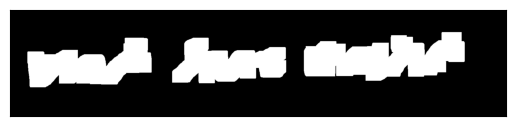

In [23]:
tes = cv.imread('/kaggle/input/tes-ygy/WhatsApp Image 2024-03-17 at 1.54.30 PM.jpeg')
gray = cv.cvtColor(tes, cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray, (9,9), 0)
_, thresh = cv.threshold(blur, 150, 255, cv.THRESH_BINARY_INV)

kernel = cv.getStructuringElement(cv.MORPH_RECT, (5,5))
morph_open = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)

kernel2 = cv.getStructuringElement(cv.MORPH_RECT, (10,7))
dilation = cv.dilate(morph_open, kernel2, iterations=5)

contours, _ = cv.findContours(dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda ctr: cv.boundingRect(ctr)[1])

list_kata = []
for contour in contours[::-1]:
    x, y, w, h = cv.boundingRect(contour)
    crop_img = thresh[y:y + h, x:x + w]
    list_kata.append(crop_img)
    

showImage(dilation)

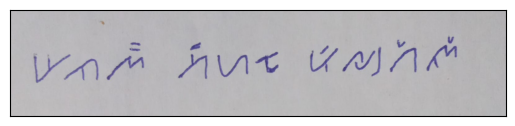

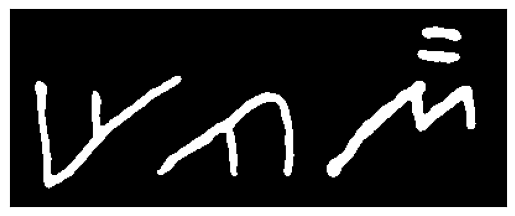

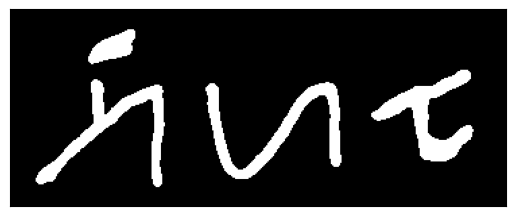

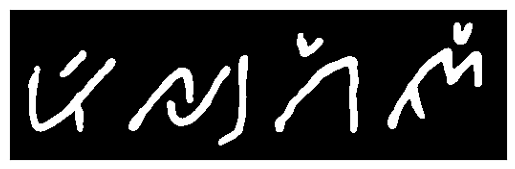

In [24]:
showImage(tes)
for k in list_kata:
    showImage(k)

'NgauMarLanWang PSangRuWang RBaiWiJi'

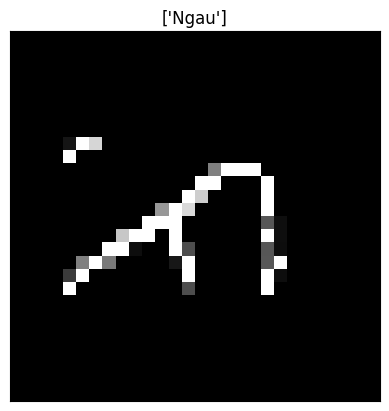

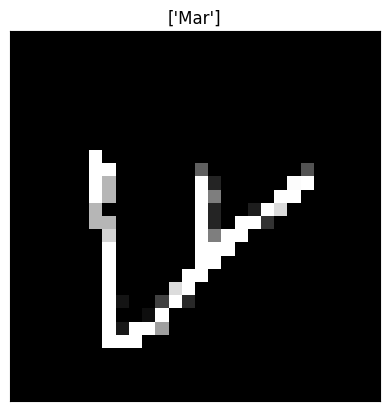

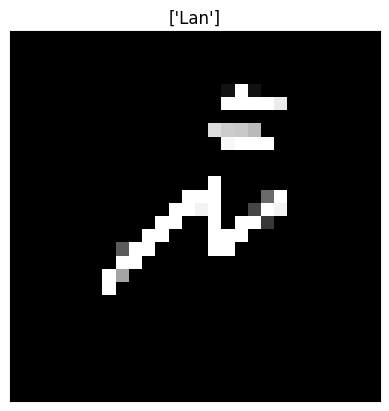

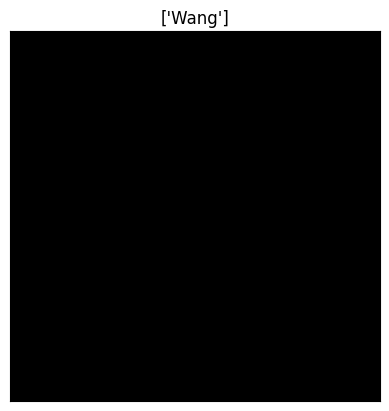

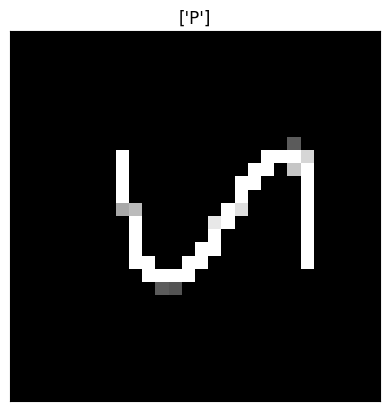

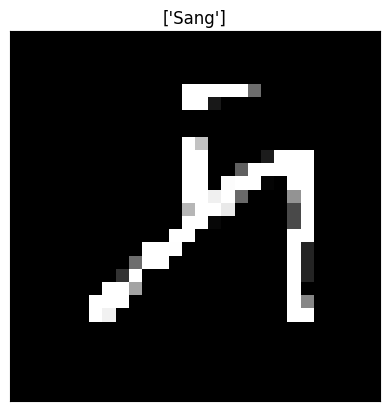

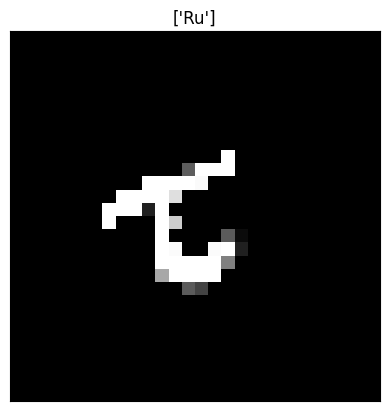

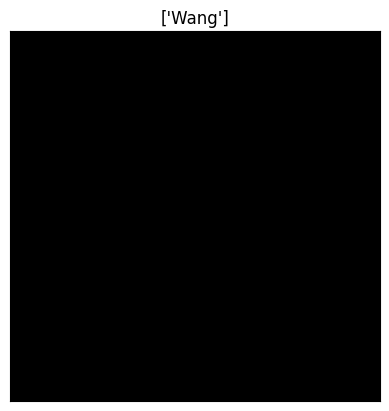

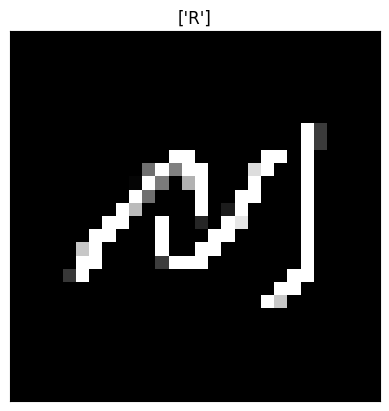

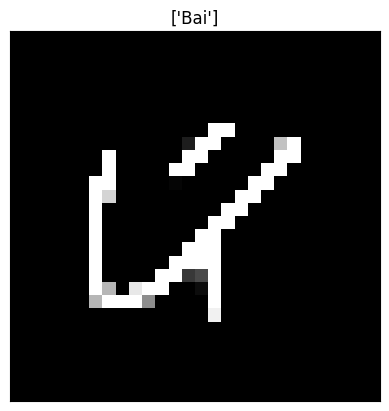

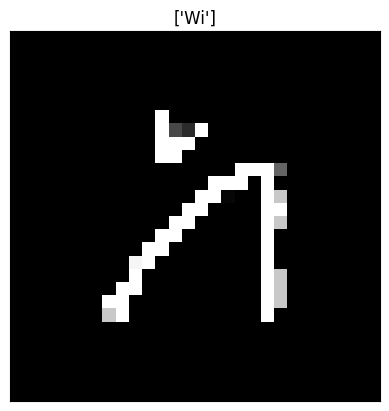

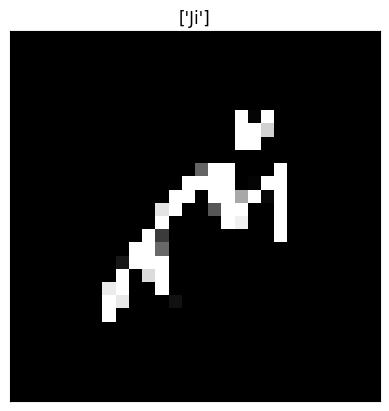

In [28]:
teks = []
for kata in list_kata:
    hasil_kata = ""
    kernel_aksara = cv.getStructuringElement(cv.MORPH_RECT, (5,15))
    dilation_aksara = cv.dilate(crop_img, kernel_aksara, iterations=2)
    
    contours, _ = cv.findContours(dilation_aksara, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda ctr: cv.boundingRect(ctr)[1])
    for aksara in contours[::-1]:
        x, y, w, h = cv.boundingRect(aksara)
        gambar_aksara = kata[y:y + h, x:x + w]
#         image = cv.imread(file)
#         gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
#         blur = cv.GaussianBlur(gray, (9, 9), 0)
#         _, thresh = cv.threshold(blur, 150, 255, cv.THRESH_BINARY_INV)
        kotak = buatKotak(gambar_aksara)
        margin = tambahMargin(kotak, .4)
        resized = cv.resize(margin, (28, 28))
        to_predict = resized.reshape(1, *resized.shape, 1)
        predicted = le.inverse_transform([np.argmax(model.predict(to_predict, verbose=0))])
        showImage(resized, predicted)
        hasil_kata += predicted[0]
    teks.append(hasil_kata)
" ".join(teks)

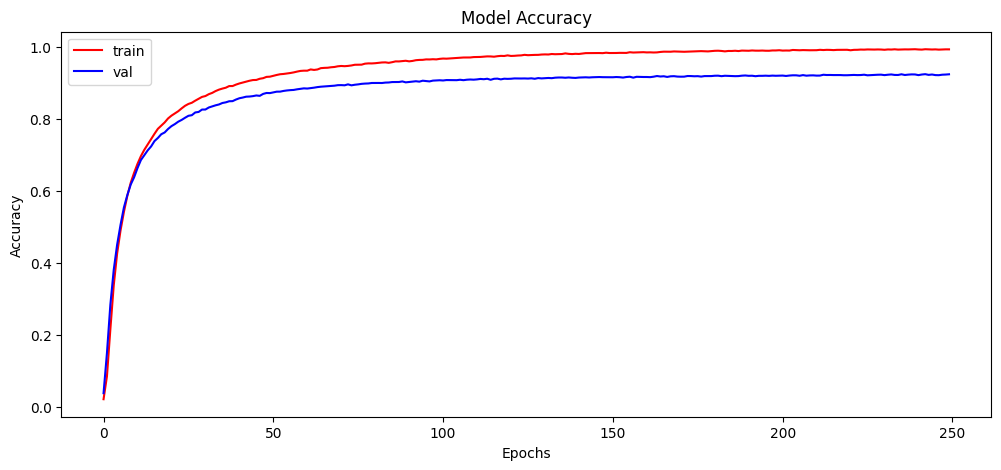

In [92]:
# Saving model
# model.save("/content/flower_species.h5")
# Let's visualize the model training and loss history.
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()